# Boosting a decision stump

The goal of this notebook is to implement a boosting module.

* Use SFrames to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement AdaBoost ensembling.
* Use implementation of AdaBoost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of AdaBoost to overfitting.

## Ye Olde Importes

In [22]:
import graphlab
from math import log
from math import exp
import matplotlib.pyplot as plt

%matplotlib inline

# Getting the data ready

We will be using the same [LendingClub](https://www.lendingclub.com/) dataset as in the previous assignment.

In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

### Extracting the target and the feature columns

Feature processing steps that we saw in the previous assignment:

Re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length']         # number of years of employment
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : 1 if x == 0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

### Subsample dataset to make sure classes are balanced

In [4]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
ratio = len(risky_loans_raw) / float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(ratio, seed = 1)
loans_data = risky_loans_raw.append(safe_loans)

print "Proportion safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Proportion risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Proportion safe loans                 : 0.502236174422
Proportion risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


### Transform categorical data into binary features

In [5]:
loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: { x: 1 })    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

Look at feature columns:

In [6]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features

['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

### Train-test split

In [7]:
train_data, test_data = loans_data.random_split(0.8, seed = 1)

# Weighted decision trees

Modify the decision tree code from before to support weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Function to compute weight of mistakes

Calculate the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

Compute the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** first computes two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** returns the lower of the two weights of mistakes, along with the class associated with that weight.

In [8]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    sum_w_negative = sum(data_weights[labels_in_node == -1]) # predict positive if lower
    sum_w_positive = sum(data_weights[labels_in_node == 1])  # predict negative if lower
    
    if sum_w_negative <= sum_w_positive:
        return (sum_w_negative, 1)
    else:
        return (sum_w_positive, -1)

### Function to pick best feature to split on

Further modify decision tree code to incorporate weighting of individual data points. 
Pick the best feature to split on.

The **best_splitting_feature** function is similar to the earlier one, but with two minor modifications:
  1. The function **best_splitting_feature** now accepts an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.

In [10]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    # Track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features: 
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]

        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(
            left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(
            right_split[target], right_data_weights)
        
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / sum(data_weights)
        
        # Update best_fearture and best_error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    return best_feature

Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

The code above obtains $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
Then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

Recall from the previous notebooks that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }

In [12]:
def create_leaf(target_values, data_weights): 
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

Function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [13]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" 
           %(splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return { 'is_leaf'          : False, 
             'prediction'       : None,
             'splitting_feature': splitting_feature,
             'left'             : left_tree, 
             'right'            : right_tree }

Count the nodes in a tree:

In [14]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

### Making predictions with a weighted decision tree

Function that classifies one data point. It can also return the probability.

In [16]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" %tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" %(tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [17]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [18]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Fit a weighted decision tree with `max_depth = 2`.

In [19]:
# Assign weights
example_data_weights = graphlab.SArray([1.] * 10 + [0.] * (len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(
    train_data, features, target, example_data_weights, max_depth = 2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership.RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade.F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade.D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

Compute the classification error on the `subset_20`, i.e., the subset of data points whose weight is 1 (the first and last 10 data points).

In [20]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

Compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [21]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

Meaning:
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are ignored during training.

# Implementing AdaBoost (on decision stumps)

For the sake of simplicity, use only **decision tree stumps** by training trees with **`max_depth = 1`**.

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

In [23]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = graphlab.SArray([1.] * len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'AdaBoost Iteration %d' %t
        print '====================================================='        

        # Learn a weighted decision tree stump. Use max_depth = 1
        tree_stump = weighted_decision_tree_create(
            data, features, target, data_weights = alpha, max_depth = 1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Produce a Boolean array indicating whether each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = sum(alpha[is_wrong]) / sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 0.5 * log((1 - weighted_error) / weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        alpha *= adjustment
        alpha = alpha / sum(alpha)
    
    return weights, tree_stumps

### Checking AdaBoost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. Run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [24]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps = 2)

AdaBoost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
AdaBoost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


In [25]:
def print_stump(tree):
    split_name = tree['splitting_feature']
    if split_name is None:
        print "(leaf, label: %s)" %tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       root'
    print '         ----------------|-----------------'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        %(('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
          ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

First stump:

In [26]:
print_stump(tree_stumps[0])

                       root
         ----------------|-----------------
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]            [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Next stump:

In [27]:
print_stump(tree_stumps[1])

                       root
         ----------------|-----------------
         |                                |
         |                                |
         |                                |
  [grade.A == 0]                    [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [28]:
print stump_weights

[0.15802933659263743, 0.1768236329364191]


### Training a boosted ensemble of 10 stumps

Train an ensemble of 10 decision tree stumps with AdaBoost. Run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [29]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(
    train_data, features, target, num_tree_stumps = 10)

AdaBoost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
AdaBoost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
AdaBoost Iteration 2
---------------------------------

## Making predictions

To make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

So:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

In [30]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = graphlab.SArray([0.] * len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x))
        # Accumulate predictions on scores array
        scores += predictions
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [31]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = graphlab.evaluation.accuracy(test_data[target], predictions)
print 'Accuracy of 10-component ensemble = %s' %accuracy 

Accuracy of 10-component ensemble = 0.62376130978


Take a look at the `stump_weights` at the end of each iteration of the 10-stump ensemble:

In [32]:
stump_weights

[0.15802933659263743,
 0.1768236329364191,
 0.09311888971129693,
 0.07288885525840554,
 0.06706306914118143,
 0.06456916961644449,
 0.05456055779178564,
 0.04351093673362621,
 0.028988711500412448,
 0.025962509691520315]

Note that weight do not typically decrease monotonically

# Performance plots

### How does accuracy change with adding stumps to the ensemble?

Train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Then:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

In [33]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(
    train_data, features, target, num_tree_stumps = 30)

AdaBoost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
AdaBoost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
AdaBoost Iteration 2
---------------------------------

### Computing training error at the end of each iteration

Compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [34]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - graphlab.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" %(n, error_all[n - 1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.434047926069
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.405061250806
Iteration 5, training error = 0.386202450032
Iteration 6, training error = 0.384348807221
Iteration 7, training error = 0.384241349667
Iteration 8, training error = 0.382924994627
Iteration 9, training error = 0.382924994627
Iteration 10, training error = 0.380265420159
Iteration 11, training error = 0.382333978079
Iteration 12, training error = 0.384886094992
Iteration 13, training error = 0.384080163335
Iteration 14, training error = 0.385584569095
Iteration 15, training error = 0.386847195358
Iteration 16, training error = 0.381044487427
Iteration 17, training error = 0.380587792822
Iteration 18, training error = 0.380587792822
Iteration 19, training error = 0.385718891038
Iteration 20, training error = 0.387841177735
Iteration 21, training error = 0.386148721255
Iteration 22, training error = 0.3881635503

### Visualizing training error vs number of iterations

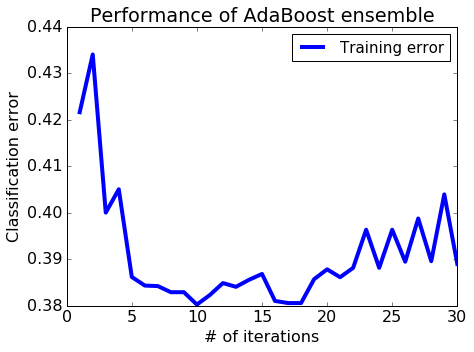

In [38]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of AdaBoost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc = 'best', prop = { 'size':15 })

plt.rcParams.update({ 'font.size': 16 })

### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Compute the classification error on the `test_data` at the end of each iteration.

In [36]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - graphlab.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, test error = %s" %(n, test_error_all[n - 1])

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.429125376993
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.379577768203
Iteration 6, test error = 0.378823782852
Iteration 7, test error = 0.378931495045
Iteration 8, test error = 0.377638948729
Iteration 9, test error = 0.377638948729
Iteration 10, test error = 0.37623869022
Iteration 11, test error = 0.379900904782
Iteration 12, test error = 0.379793192589
Iteration 13, test error = 0.382593709608
Iteration 14, test error = 0.379900904782
Iteration 15, test error = 0.387009909522
Iteration 16, test error = 0.377854373115
Iteration 17, test error = 0.37731581215
Iteration 18, test error = 0.37731581215
Iteration 19, test error = 0.38517880224
Iteration 20, test error = 0.382270573029
Iteration 21, test error = 0.385717363206
Iteration 22, test error = 0.382378285222
Iteration 23, test error = 0.400797070228
Iteration 24, test error = 0.382378285222
Iterat

### Visualize both the training and test errors

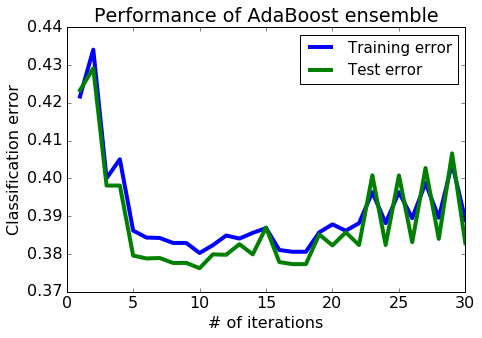

In [39]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of AdaBoost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({ 'font.size': 16 })
plt.legend(loc='best', prop={ 'size':15 })
plt.tight_layout()